# 1. Introdução
------
Este notebook tem por objetivo ensinar como utilizar a biblioteca do GPA, além de apresentar alguns testes de hipercubos fundamentais. 


Rode a célula a seguir, caso esteja utilizando o colab

In [ ]:
!pip install git+https://github.com/rsautter/GPA@V4

  Cloning https://github.com/rsautter/GPA (to revision V4) to /tmp/pip-req-build-a45ilcin
  Running command git clone -q https://github.com/rsautter/GPA /tmp/pip-req-build-a45ilcin
  Running command git checkout -b V4 --track origin/V4
  Switched to a new branch 'V4'
  Branch 'V4' set up to track remote branch 'V4' from 'origin'.
  Created wheel for GPA: filename=GPA-4.0-py3-none-any.whl size=6848 sha256=2d8d23b586fdcb4af96f152c71fb1ae1b4557f32eeb7d66ce392a49ced6fb8c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-5radi3zj/wheels/01/38/8c/486d2777ffb87ef75c1e4c2e337125cd566f094df5fe460043
Successfully built GPA


A célula a seguir invoca as bibliotecas de manipulação de vetores, plotagem e o próprio GPA 

In [ ]:
from GPA3D import GPA3D
import matplotlib.pyplot as plt
import numpy as np

from matplotlib import colors
import matplotlib.patches as mpatches

# 2. Utilizando o GPA
------
O GPA foi implementado como um objeto que analisa vetores do tipo numpy. Parte do algoritmo consiste na detecção de simetrias no padrão, nesta implementação foi adotado a simetria concêntrica/rotacional. Neste tipo de simetria vetores que estão equidistantes ao centro padrão são comparados entre si. Caso exista ao menos um vetor cuja soma seja o vetor nulo, então este vetor é dito simétrico. 

A figura a seguir mostra um exemplo do processo de detecção de simetria concêntrica, o círculo mostra uma determinada distância avaliada. Neste padrão todos os vetores são simétricos, pois para cada vetor existe um outro vetor a 180º em relação ao centro, com módulo igual e fase oposta.

<img src='https://raw.githubusercontent.com/rsautter/GPA/master/Figures/Remotion.png'>

Há um parâmetro de tolerância que é fornecido ao método construtor do GPA, para avaliar se dois pares de vetores são simétricos. No exemplo a seguir, a tolerância é 0.01, porém qualquer medida entre zero e um pode ser considerada. Este parâmetro determina a partir do maior vetor no padrão a ser analisado qual a tolerância do algoritmo de detecção de simetria.

In [ ]:
ga = GPA3D(0.01)

In [ ]:
mat = [
        [[0,0,0],
        [0,1,0],
        [0,0,0]],

        [[0,1,0],
        [1,2,1],
        [0,1,0]],

        [[0,0,0],
        [0,1,0],
        [0,0,0]]
       ]
mat = np.array(mat)

O método \_\_*call*\_\_ realiza a medida dos momentos do campo gradiente. Há três parâmetros:

 - mat - A matriz de entrada do tipo float
 - moment - Lista de momentos do campo gradiente a serem medidos ('G1','G2','G3' ou 'G4')
 - symmetrycalGrad - Determina se a medida será realizada sobre o campo simétrico, codificado como:
    - 'S'  - campo simétricos
    - 'A'  - campo assimétrico
    - 'F'  - campo gradiente completo (G4 não pode ser medido neste modo)
    - 'K'  - campo gradiente completo, exceto por vetores nulos


Por padrão os parâmetros são:

    moment = ['G2']
    symmetrycalGrad = 'A'

Neste exemplo a matriz é completamente simétrica.

In [ ]:
moments = ga(mat, moment=['G1','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente simétrico: {'G1': 2.833, 'G2': 0.996, 'G3': 0.0, 'G4': (8.88576587631673 + 3.41421356237309*pi) + 0*i + 0*j + 0*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 2.833, 'G2': 0.667, 'G3': 0.0, 'G4': (8.88576587631673 + 3.41421356237309*pi) + 0*i + 0*j + 0*k}
Momentos do campo gradiente completo: {'G1': 3.963, 'G2': 1.0, 'G3': 0.637}


## 2.1. Momentos do Campo Gradiente

###  Primeiro Momento  do Campo Gradiente ($G_1$)
O primeiro momento do campo gradiente é calculado a partir da triangulação de Delaunay. A medida é a razão entre o número de conexões ($N_C$) em relação ao número de vetores ($N_V$). Por meio de testes [(ROSA et. al., 1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), foi constatado que a medida está limitada ao intervalo \[0, 2\[. O motivo para tal limite ainda é desconhecido.   

$$G_1 = {N_C-N_V \over N_V} = {N_C \over N_V}-1$$

Uma medida alternativa para o primeiro momento, que é normalizada, é dado por:

$$G^N_1 = e^{- {N_V \over N_C}}$$


### Segundo Momento do Campo Gradiente Assimétrico ($G_2$)
O segundo momento do campo gradiente é uma medida que relacionada a proporção de vetores assimétricos(${V_A / V}$) e a variabilidade dos módulos ($ {|\sum v^A| / \sum|v^A|}$) . Esta medida era ajustada ao intervalo $[0,2]$, conforme descrito por [Barchi, et.al.,(2017)](https://arxiv.org/abs/1705.06818), com o intuito de comparar aos demais momentos do campo gradiente. Atualmente essa medida é normalizada ao intervalo $[0,1]$

$$ G_2 = {V_A \over V} \left( 1 - {|\sum v^A|\over 2\sum|v^A|}\right)$$

### Segundo Momento do Campo Gradiente Simétrico ($G^S_2$)
A medida utilizada no segundo momento do campo gradiente assimétrico não é útil para muito casos de campos simétricos. Por exemplo, O somatório de vetores simétricos é sempre zero ($|\sum v^S| = 0$), tornando a medida constante para o caso de um padrão simétrico bilateralmente. Como alternativa, utiliza-se equação a seguir, onde $||v^S_{i,j}||$ é o módulo de um determinado vetor simétrico, normalizado pelo maior módulo de vetor simétrico.

$$G^S_2 = - \sum ||v^S||ln\left(||v^S||\right)$$
 
###  Terceiro Momento do Campo Gradiente ($G_3$)

Toda medida realizada exclusivamente sobre o conjunto de fases de um campo gradiente pertence ao terceiro momento do campo gradiente, segundo formalismo da análise de padrões do campo gradiente. Uma medida possível é a variabilidade das fases, onde $\sigma$ é o desvio padrão. Na equação a seguir $u$ e $v$ são vetores unitários, cuja direção indica, respectivamente, a direção do gradiente em um dado ponto e a direção desse vetor em relação ao centro de simetria.

$$G_3 = \sigma (u.v)$$

Em um caso 2D, o conjunto de fases $\theta_i$ posicionada ao respectivo ângulo $\phi_i$ em relação ao centro, tem como terceiro momento:

$$G_3 = \sigma( cos(\theta_i)cos(\phi_i)+sin(\theta_i)sin(\phi_i) )$$

O produto nessa medida, pode ser visto como uma mudança para o referencial do centro de simetria, uma vez que por definição o produto interno é:

$$u.v = |u||v|cos(\gamma) = cos(\gamma)$$

A figura a seguir mostra a relação entre os vetores $u$ e $v$ e a resposta do produto interno. 
<center>
<img src='https://raw.githubusercontent.com/rsautter/GPA/master/Figures/G3Exp.png'>
</center>

###  Quarto Momento do Campo Gradiente ($G_4$)

O quarto momento do campo gradiente é definido por medidas da representação  complexa, onde $z_{x,y} = a+ bi$.
 [Neto, et. al.(2000)](https://www.worldscientific.com/doi/abs/10.1142/S0129183101002504?casa_token=WD_wImLA5_AAAAAA:L0DMr350Si3FPygbvYx4KZAPLrw6l1oiBJ3TjyvqBQlNSeGM1K-jjsv_RHXXd5IHuLZeDZvqWBeIzeQ) propôem uma medida de entropia da forma complexa do campo gradiente, conforme a equação abaixo, onde $z=\sum z_{i,j}$

 $$ G_4 = - \sum {z_{x,y} \over z} ln \left( {z_{x,y} \over z}  \right)$$

Para o caso tridimensional, o número complexo é representado por [quaternions](https://en.wikipedia.org/wiki/Quaternion), cuja implementação provém da biblioteca [Sympy](https://docs.sympy.org/latest/modules/algebras.html). Por definição esse sistema numérico possui um número escalar e três números complexos, tal que: 

$$z_{x,y,z} = a +bi++cj+dk = a + v $$

O logaritmo natural nesse sistema é calculado como:

$$ ln(z_{x,y,z})  = ln |z| + {v \over |v|} arccos \left( {a \over |q|} \right) $$

Afim de evitar um erro de aproximação , considera-se apenas a parte real do quaternion resultante quando a parte complexa do quaternion original é nula ($|v| = 0.0$). O principal motivo é que neste caso, o vetor aponta em apenas no eixo dos números reais, sendo assim possível aproximar a função logaritmica do quaternion, como a função logaritmica dos números reais.

## 2.2. Plot


O plot a seguir mostra a matriz de amplitudes, o campo gradiente e a classificação dos vetores quanto a simetria. Infelizmente, para o caso de um padrão somente com vetores indeterminados, como uma matriz constante, a função [quiver](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.quiver.html) não funciona propriamente.

Outro aspecto importante é que por padrão matrizes numpy possuem origem no canto superior esquerdo, enquanto o padrão da matplotlib a origem é o canto inferior esquerdo.

(3, 3, 3)


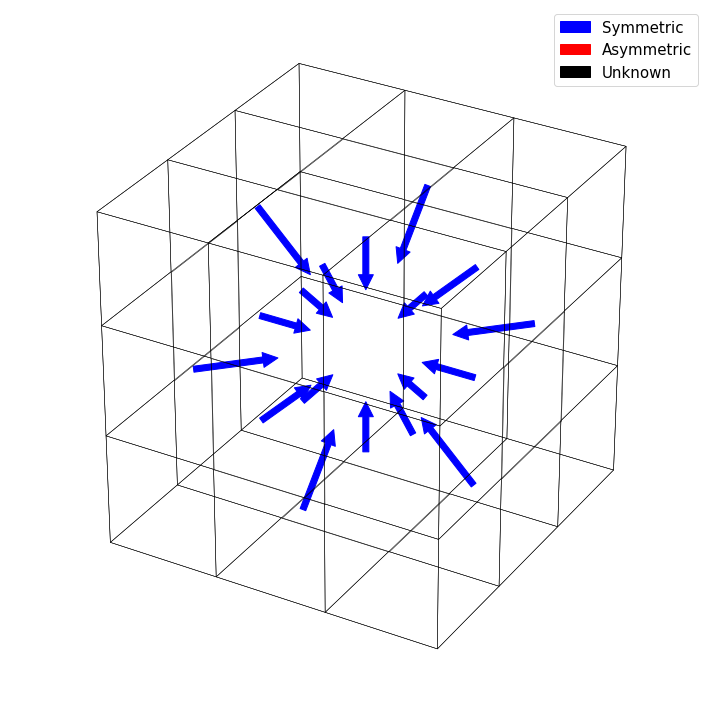

In [ ]:
from matplotlib.patches import FancyArrowPatch, Patch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

def plotGPAVecClass(mat,ga,scale = 0.5):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
 
    x, y, z = np.indices(np.array(ga.gradient_dx.shape)+1)
    filled = np.ones((ga.gradient_dx.shape))
    print(filled.shape)
    ax.voxels(x,y,z,filled, facecolors=[0,0,0,0], edgecolor='black',lw=0.5)


    for x in range(ga.gradient_dx.shape[0]):
      for y in range(ga.gradient_dx.shape[1]):
        for z in range(ga.gradient_dx.shape[2]):
          if ga.asymmetricalP[x,y,z] ==1:
            arrow = Arrow3D([x+0.5, x+scale*ga.gradient_dx[x,y,z] +0.5], [y+0.5, y+scale*ga.gradient_dy[x,y,z]+0.5 ], [z+0.5, z+scale*ga.gradient_dz[x,y,z]+0.5 ],
                          mutation_scale=30, shrinkA=1.5, shrinkB=1.5, color='r')
          elif ga.symmetricalP[x,y,z] == 1:
            arrow = Arrow3D([x+0.5, x+scale*ga.gradient_dx[x,y,z] +0.5], [y+0.5, y+scale*ga.gradient_dy[x,y,z]+0.5 ], [z+0.5, z+scale*ga.gradient_dz[x,y,z]+0.5 ],
                          mutation_scale=30, shrinkA=1.5, shrinkB=1.5, color='b')
          else:
            arrow = Arrow3D([x+0.5, x+scale*ga.gradient_dx[x,y,z] +0.5], [y+0.5, y+scale*ga.gradient_dy[x,y,z]+0.5 ], [z+0.5, z+scale*ga.gradient_dz[x,y,z]+0.5 ],
                          mutation_scale=30, shrinkA=1.5, shrinkB=1.5, color='k')
          ax.add_artist(arrow)
    
    ax.legend(handles=[
                        Patch(color='blue', label='Symmetric'),
                        Patch(color='red', label='Asymmetric'),
                        Patch(color='black', label='Unknown')], fontsize=15)
  
    ax.set_xlim(0,ga.gradient_dx.shape[0])
    ax.set_ylim(0,ga.gradient_dx.shape[1])
    ax.set_zlim(0,ga.gradient_dx.shape[2])
    ax.set_axis_off()
    plt.tight_layout()
          
    plt.show()
    
plotGPAVecClass(mat,ga)

# 3. Matrizes Fundamentais
------

O conceito original de matriz fundamental foi estabelecido por [Rosa et. al., (1999)](https://www.worldscientific.com/doi/abs/10.1142/S0129183199000103), como a menor matriz que possui um elemento central, ou seja uma matriz fundamental 2D de tamanho 3x3. Este tipo de padrão é importante para entender os algoritmos propostos e validar a implementação.


Neste sentido, são apresentados quatro categorias de matrizes fundamentais:

    - simétricas
    - assimétricas
    - indeterminado
    - misto

## 3.1. Simétrica

In [ ]:
mat = [
        [[0,0,0],
        [0,-1,0],
        [0,0,0]],

        [[0,1,0],
        [1,2,1],
        [0,1,0]],

        [[0,0,0],
        [0,-1,0],
        [0,0,0]]
       ]
mat = np.array(mat)

moments = ga(mat, moment=['G1','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)


Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente simétrico: {'G1': 3.278, 'G2': 0.98, 'G3': 0.497, 'G4': (4.18879020478639 + 1.60947570824873*pi) + 0*i + 0*j + 0*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 3.278, 'G2': 0.667, 'G3': 0.497, 'G4': (4.18879020478639 + 1.60947570824873*pi) + 0*i + 0*j + 0*k}
Momentos do campo gradiente completo: {'G1': 3.704, 'G2': 1.0, 'G3': 0.629}


(3, 3, 3)


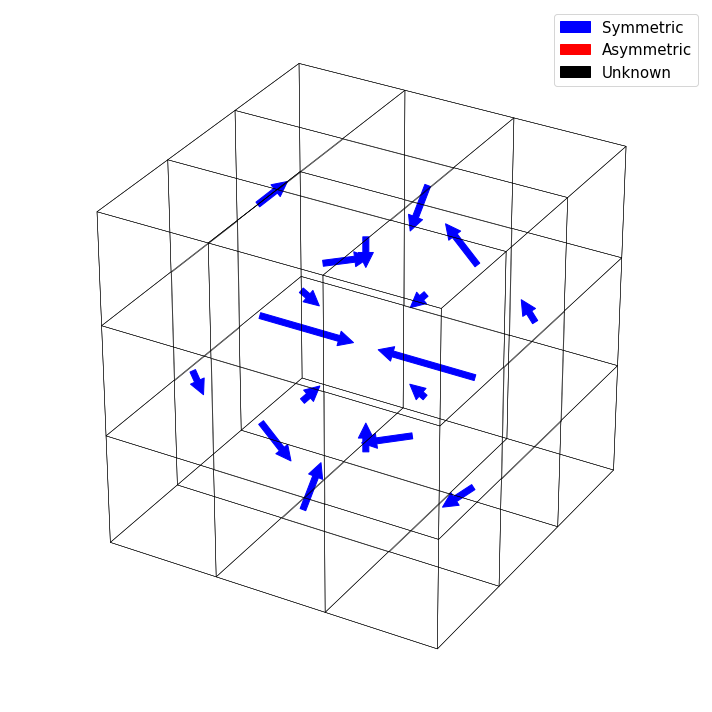

In [ ]:
plotGPAVecClass(mat,ga,scale=0.3)

## 3.2. Assimétrico

In [ ]:
mat = [
       [[3,7,2],
       [6,0,6],
       [4,7,4]],
       
       [[3,6,4],
       [6,0,6],
       [4,7,4]],

       [[6,6,4],
       [6,5,6],
       [4,7,4]]
]
mat = np.array(mat)


moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 4.154, 'G1N': 0.824, 'G2': 0.932, 'G3': 0.795, 'G4': (6.68301225099636 + 5.17826091250353*pi) + (-1.36613983422237)*i + (-0.113978573418727)*j + (-1.38777878078145e-17 + 2.77555756156289e-17*pi)*k}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 4.154, 'G1N': 0.824, 'G2': 0.898, 'G3': 0.795, 'G4': (6.68301225099636 + 5.17826091250353*pi) + (-1.36613983422237)*i + (-0.113978573418727)*j + (-1.38777878078145e-17 + 2.77555756156289e-17*pi)*k}
Momentos do campo gradiente completo: {'G1': 4.185, 'G1N': 0.825, 'G2': 0.932, 'G3': 0.802}


(3, 3, 3)


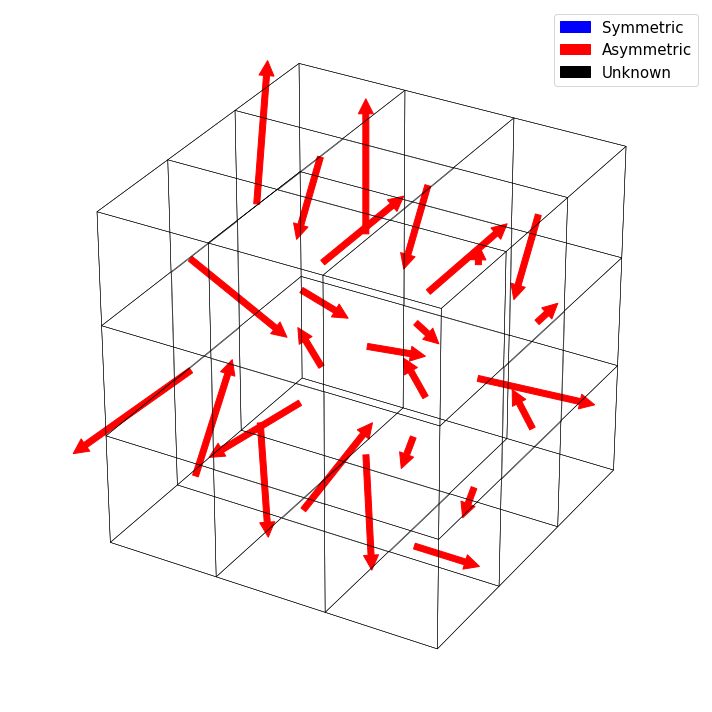

In [ ]:
plotGPAVecClass(mat,ga,scale=0.2)

## 3.3. Misto

In [ ]:
mat = [
       [[3,7,2],
       [6,1,7],
       [4,8,4]],
       
       [[3,6,4],
       [6,0,6],
       [4,7,4]],

       [[2,5,4],
       [5,5,6],
       [4,6,3]]
]
mat = np.array(mat)


moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 4.0, 'G1N': 0.819, 'G2': 0.867, 'G3': 0.828, 'G4': (1.27188359942087*pi + 16.6016142513152) + 0.888614927021131*i + 1.76262836675541*j + 1.38777878078145e-17*k}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 1.0, 'G3': 0.017, 'G4': 0.680413817439772*pi + 0*i + 0*j + (-5.55111512312578e-17*pi)*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 4.074, 'G1N': 0.821, 'G2': 0.942, 'G3': 0.822, 'G4': (1.95229741686065*pi + 16.6016142513152) + 0.888614927021131*i + 1.76262836675541*j + (1.38777878078145e-17 - 5.55111512312578e-17*pi)*k}
Momentos do campo gradiente completo: {'G1': 4.074, 'G1N': 0.821, 'G2': 0.942, 'G3': 0.822}


(3, 3, 3)


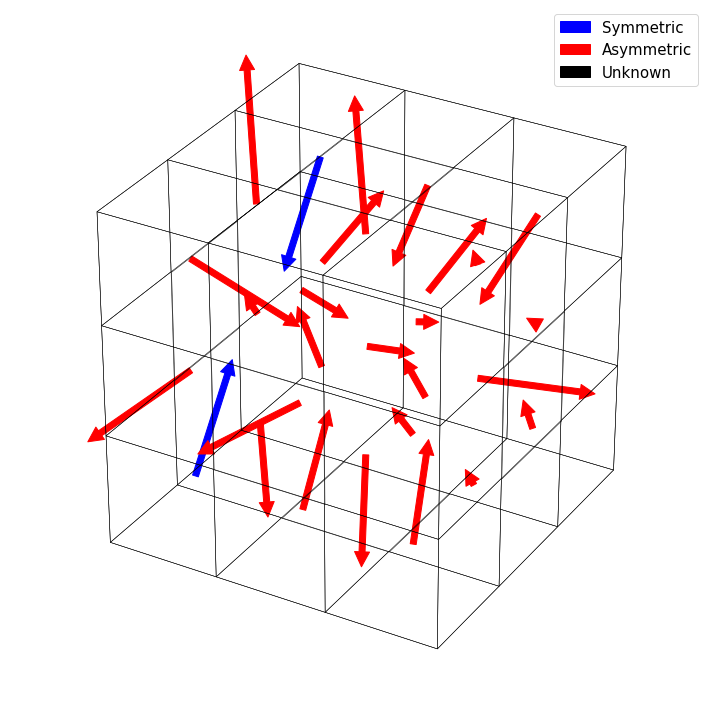

In [ ]:
plotGPAVecClass(mat,ga,scale=0.2)

In [ ]:
mat = [
       [[3,7,2],
       [6,1,7],
       [4,8,4]],
       
       [[3,6,4],
       [6,0,6],
       [4,7,4]],

       [[2,5,4],
       [5,5,8],
       [4,8,5]]
]
mat = np.array(mat)


moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)

Momentos do campo gradiente assimétrico: {'G1': 3.87, 'G1N': 0.814, 'G2': 0.762, 'G3': 0.848, 'G4': (1.92889399215913*pi + 14.0393964482999) + 0.574871150132597*i + 1.75310906342022*j + 1.38777878078145e-17*k}
Momentos do campo gradiente simétrico: {'G1': 0.5, 'G1N': 0.513, 'G2': 0.998, 'G3': 0.058, 'G4': (1.81379936423422 + 0.680413817439772*pi) + 0.302299894039036*i + 0.302299894039036*j + (-5.55111512312578e-17*pi)*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 4.259, 'G1N': 0.827, 'G2': 0.911, 'G3': 0.838, 'G4': (2.6093078095989*pi + 15.8531958125341) + 0.877171044171634*i + 2.05540895745925*j + (1.38777878078145e-17 - 5.55111512312578e-17*pi)*k}
Momentos do campo gradiente completo: {'G1': 4.259, 'G1N': 0.827, 'G2': 0.911, 'G3': 0.838}


(3, 3, 3)


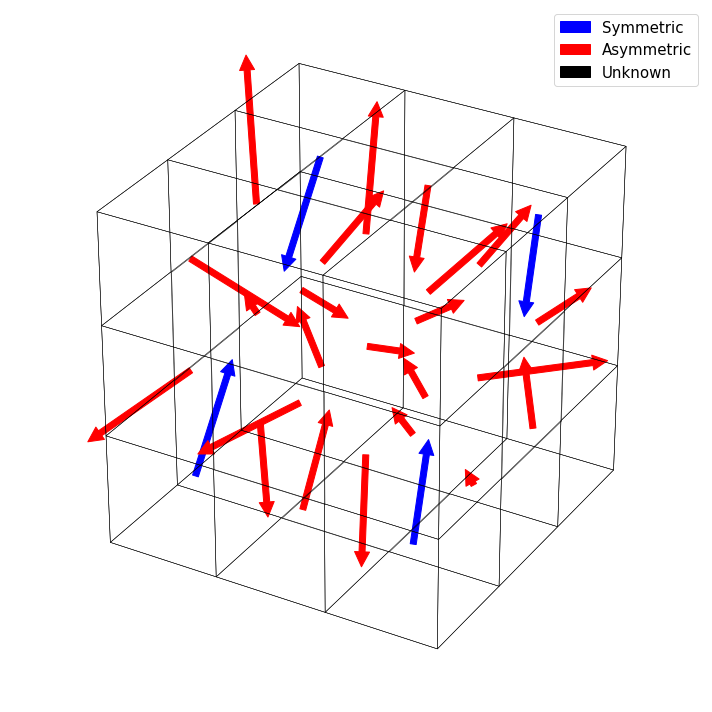

In [ ]:
plotGPAVecClass(mat,ga,scale=0.2)

## 3.4. Indeterminado

In [ ]:
mat = [[[0,0,0],
       [0,0,0],
       [0,0,0]],

      [[0,0,0],
       [0,0,0],
       [0,0,0]],

      [[0,0,0],
       [0,0,0],
       [0,0,0]]
]

mat = np.array(mat)


moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='A')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente assimétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='S')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente simétrico:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3','G4'],symmetrycalGrad='K')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente, exceto vetores indeterminados:",moments)

moments = ga(mat, moment=['G1','G1N','G2','G3'],symmetrycalGrad='F')
moments = {key : np.round(moments[key],3) if key !='G4' else moments[key] for key in moments}
print("Momentos do campo gradiente completo:",moments)


Momentos do campo gradiente assimétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente simétrico: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente, exceto vetores indeterminados: {'G1': 0.0, 'G1N': 0.0, 'G2': 0.0, 'G3': 0.0, 'G4': 0 + 0*i + 0*j + 0*k}
Momentos do campo gradiente completo: {'G1': 3.0, 'G1N': 0.779, 'G2': 1.0, 'G3': 0.597}


# Referências

[1] Rosa, Reinaldo R., A. S. Sharma, and J. A. Valdivia. "Characterization of asymmetric fragmentation patterns in spatially extended systems." International Journal of Modern Physics C 10.01 (1999): 147-163.

[2] Barchi, P. H., et al. "Improving galaxy morphology with machine learning." arXiv preprint arXiv:1705.06818 (2017).

[3] Neto, C. Rodrigues, R. R. Rosa, and F. M. Ramos. "Pattern characterization: A case study in osmosedimentation." International Journal of Modern Physics C 12.08 (2001): 1261-1269.

### Extra - Plot

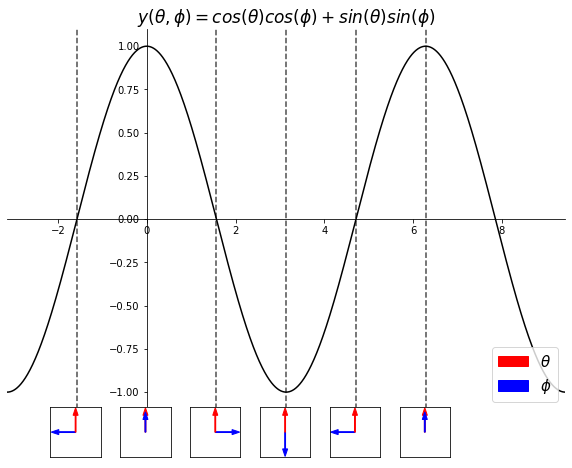

In [ ]:

fig = plt.figure(figsize=(10,7))

ax = plt.subplot(1,1,1)
x = np.linspace(-np.pi,3*np.pi,2000)
y = np.cos(x)
plt.plot(x,y,color='k')
plt.xlim(-np.pi,3*np.pi)

ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')

plt.axvline(-np.pi/2,c='k',ls='--',alpha=0.7)
plt.axvline(np.pi,c='k',ls='--',alpha=0.7)
plt.axvline(np.pi/2,c='k',ls='--',alpha=0.7)
plt.axvline(2*np.pi,c='k',ls='--',alpha=0.7)
plt.axvline(3*np.pi/2,c='k',ls='--',alpha=0.7)
plt.title(r'$y(\theta,\phi) = cos(\theta)cos(\phi)+sin(\theta)sin(\phi)$',fontsize=17)


theta = mpatches.Patch(color='red', label=r'$\theta$')
phi = mpatches.Patch(color='blue', label=r'$\phi$')
plt.legend(handles=[theta,phi],loc='lower right',fontsize=15)


fig.add_axes([0.185,0.03,0.07,0.1])
plt.arrow(0,0,-1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

delta = 0.097
fig.add_axes([0.185+delta,0.03,0.07,0.1])
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.arrow(0,0,0,0.75,width=0.05,head_width=0.3,color='blue')

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+2*delta,0.03,0.07,0.1])
plt.arrow(0,0,1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+3*delta,0.03,0.07,0.1])
plt.arrow(0,0,0,-1,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+4*delta,0.03,0.07,0.1])
plt.arrow(0,0,-1,0,width=0.05,head_width=0.3,color='blue')
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

fig.add_axes([0.185+5*delta,0.03,0.07,0.1])
plt.arrow(0,0,0,1,width=0.05,head_width=0.3,color='red')
plt.arrow(0,0,0,0.75,width=0.05,head_width=0.3,color='blue')

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xticks([])
plt.yticks([])

mpatches
#ax.grid()

plt.show()

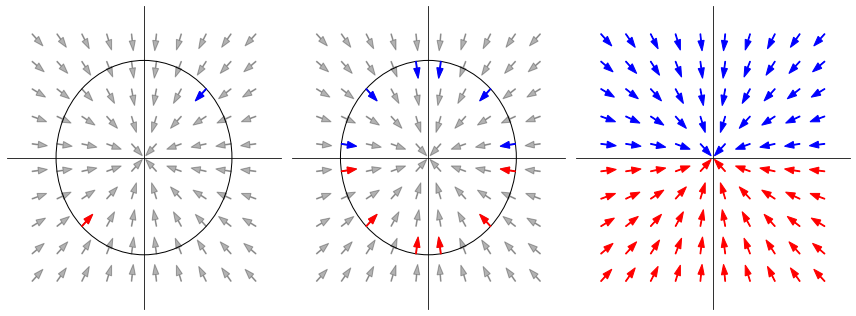

In [ ]:
n = 10
center = n//2-0.5
inverseDistanceW = 4
alpha = 0.3

plt.figure(figsize=(12,4.5))

plt.subplot(1,3,1)

for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='black',alpha=alpha)

x,y = 2,2
d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
dx,dy = center-x,center-y
dx,dy = dx/d,dy/d
plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)

x,y = 7,7
d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
dx,dy = center-x,center-y
dx,dy = dx/d,dy/d
plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

circle = plt.Circle((center, center), np.sqrt((x-center)**2+ (y-center)**2), color='k',fill=False)
ax = plt.gca()
ax.add_patch(circle)

plt.xlim(-1,10)
plt.ylim(-1,10)

ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')

plt.xticks([])
plt.yticks([])

'''
Mesma distancia
'''
dtarget = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
plt.subplot(1,3,2)
for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='black',alpha=alpha)
    if np.abs(d-dtarget) <0.3:
      if(y<center):
        plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)
      else:
        plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

x,y = 7,7
circle = plt.Circle((center, center), np.sqrt((x-center)**2+ (y-center)**2), color='k',fill=False)
ax = plt.gca()
ax.add_patch(circle)

plt.xlim(-1,10)
plt.ylim(-1,10)

ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')
plt.xticks([])
plt.yticks([])

'''
Todos removidos
'''
dtarget = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
plt.subplot(1,3,3)
for x in range(10):
  for y in range(10):
    d = inverseDistanceW*np.sqrt((x-center)**2+ (y-center)**2)+0.1
    dx,dy = center-x,center-y
    dx,dy = dx/d,dy/d
    if y<center:
      plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='red',alpha=1)
    else:
      plt.arrow(x,y,dx,dy,width=0.03,head_width=0.25,color='blue',alpha=1)

plt.xlim(-1,10)
plt.ylim(-1,10)
ax = plt.gca()
ax.spines['left'].set_position(('data', center))
ax.spines['right'].set_color('none')

ax.spines['bottom'].set_position(('data', center))
ax.spines['top'].set_color('none')

plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()